In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  %load_ext autoreload
  %autoreload 2
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github

  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.11.0+cu115 torchvision==0.12.0+cu115 torchaudio==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio,torchvision
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import metrics.metrics as metrics
from dataset.subsetSC import SubsetSC
from models.mel_model import mel_model
from utilsFunc import *

working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

Wrong working directory
/Users/carlos/Documents/LeTaffe/PROJET_ESSAI
New directory : /Users/carlos/Documents/LeTaffe/PROJET_ESSAI


In [3]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])

Using cpu


## Downloading and setting up the dataset

In [4]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    if 'train_set' not in locals():  
        train_set = SubsetSC("training",root)
    if 'test_set' not in locals():
        test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = train_set[0]

# TODO : We are doing it without resampling it.
#resample_transform=torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=new_sample_rate)

training & test sets finished in  0:01:22.451142


## Let's visualize the data !

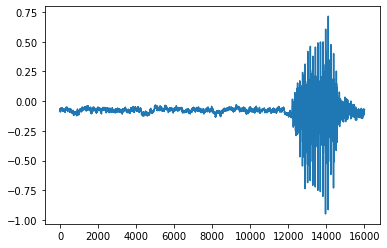

In [5]:
plt.plot(storage['waveform'].t().numpy())

(241, 98)


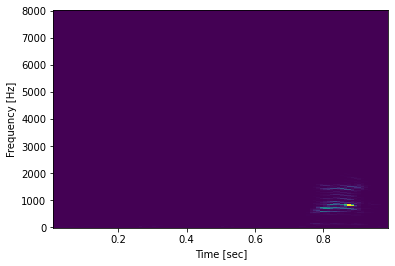

In [6]:
from scipy import signal
from scipy.fft import fftshift

fe=16000
noverlap=int(20e-3*fe)
nperseg=int(30e-3*fe)
f, t, Sxx = signal.spectrogram(storage['waveform'][0], fe,noverlap=noverlap,nperseg=nperseg)
plt.pcolormesh(t, f, Sxx)
print(Sxx.shape)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [7]:

n_mels=50

win_length=int(30e-3 *fe)
hop_length=int(10e-3 *fe)
n_fft=win_length 
spec_size=(fe -win_length)/hop_length +1
print('size of tensor should be ',spec_size)

size of tensor should be  98.0


### Mel's spectrogram

Shape of spectrogram: torch.Size([1, 50, 101])


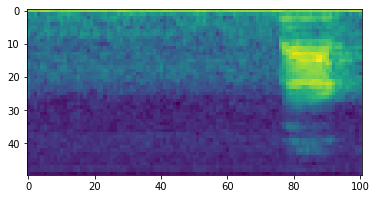

In [8]:
mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(n_fft=n_fft,
                                        n_mels=n_mels,win_length=win_length,hop_length=hop_length)
spectrogram_spec=mel_spectrogram_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(spectrogram_spec.size()))

plt.figure()
p = plt.imshow(spectrogram_spec.log2()[0].detach().numpy())

### MFCC

Shape of spectrogram: torch.Size([1, 40, 101])


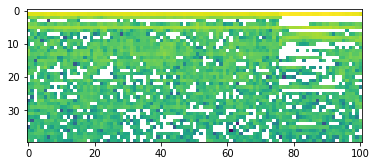

In [9]:
MFCC_transform = torchaudio.transforms.MFCC(melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    })
MFCC_spec=MFCC_transform(storage['waveform'])
print("Shape of spectrogram: {}".format(MFCC_spec.size()))

plt.figure()
p = plt.imshow(MFCC_spec.log2()[0].detach().numpy())

## Resampling the data and setting the transform

In [10]:
layers =[]
layers.append(MFCC_transform)

storage['transform'] = nn.Sequential(*layers)

waveform_size=storage['transform'](storage['waveform']).shape
print(waveform_size)

torch.Size([1, 40, 101])


## Setting up the test and train loader

In [11]:
batch_size = 100

if storage['device'] == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
    
storage['train_loader']  = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
storage['test_loader']  = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=test_set.collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the network

In [12]:
storage['model'] = mel_model(input_shape=waveform_size, n_output=len(train_set.labels))
storage['model'].to(storage['device'])
#print(storage['model'])
print("Number of parameters: %s" % storage['model'].count_parameters())

Number of parameters: 355011


## Define the optimizer, loss function & metrics

In [13]:
# Define the Optimizer
lr=0.001 
storage['optimizer'] = optim.Adam(storage['model'].parameters(), lr=lr, weight_decay=0.0001)
storage['scheduler'] = optim.lr_scheduler.StepLR(storage['optimizer'], step_size=20,
                                      gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
#Define the loss Function
storage['lossFunc']=F.cross_entropy
#Define the metrics :
storage['metrics']=metrics.countCorrectOutput

## Define the log interval and epochs

In [14]:
storage['log_interval'] = 20
storage['n_epoch'] = 100

storage['pbar_update']  = 1 / (len(storage['train_loader']) + len(storage['test_loader']))
storage['losses'] = []
# The transform needs to live on the same device as the model and the data.

storage['transform'] = storage['transform'].to(storage['device'])

## Train and testing

In [15]:
with timeThat('Main program') :
    with tqdm(total=storage['n_epoch']) as pbar:
        storage['pbar']=pbar
        for epoch in range(1, storage['n_epoch'] + 1):
            train(storage)
            test(storage)
            storage['scheduler'].step()

  0%|          | 0.0010416666666666667/2 [00:00<16:18, 489.65s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 4.508517


  1%|          | 0.021875/2 [00:10<15:21, 465.97s/it]             

Train Epoch: 2 [2000/84843 (2%)]	Loss: 3.565611


  2%|▏         | 0.04270833333333336/2 [00:19<15:05, 462.52s/it] 

Train Epoch: 2 [4000/84843 (5%)]	Loss: 3.497253


  3%|▎         | 0.06354166666666675/2 [00:29<13:37, 422.19s/it]

Train Epoch: 2 [6000/84843 (7%)]	Loss: 3.464394


  4%|▍         | 0.084375/2 [00:38<13:42, 429.55s/it]           

Train Epoch: 2 [8000/84843 (9%)]	Loss: 3.490937


  5%|▌         | 0.10520833333333326/2 [00:47<14:24, 456.50s/it]

Train Epoch: 2 [10000/84843 (12%)]	Loss: 3.424325


  6%|▋         | 0.12604166666666652/2 [00:57<15:52, 508.14s/it]

Train Epoch: 2 [12000/84843 (14%)]	Loss: 3.050725


  7%|▋         | 0.14687499999999978/2 [01:07<15:03, 487.39s/it]

Train Epoch: 2 [14000/84843 (16%)]	Loss: 3.136849


  8%|▊         | 0.16770833333333304/2 [01:17<13:34, 444.57s/it]

Train Epoch: 2 [16000/84843 (19%)]	Loss: 3.046230


  9%|▉         | 0.1885416666666663/2 [01:26<12:44, 422.27s/it] 

Train Epoch: 2 [18000/84843 (21%)]	Loss: 3.133265


 10%|█         | 0.20937499999999956/2 [01:35<13:14, 443.55s/it]

Train Epoch: 2 [20000/84843 (24%)]	Loss: 3.068102


 12%|█▏        | 0.23020833333333282/2 [01:44<12:19, 417.61s/it]

Train Epoch: 2 [22000/84843 (26%)]	Loss: 2.981606


 13%|█▎        | 0.2510416666666661/2 [01:54<17:01, 584.16s/it] 

Train Epoch: 2 [24000/84843 (28%)]	Loss: 3.122323


 14%|█▎        | 0.27187499999999937/2 [02:04<13:33, 470.95s/it]

Train Epoch: 2 [26000/84843 (31%)]	Loss: 2.830780


 15%|█▍        | 0.2927083333333326/2 [02:14<13:08, 461.86s/it] 

Train Epoch: 2 [28000/84843 (33%)]	Loss: 2.836787


 16%|█▌        | 0.3135416666666659/2 [02:23<12:15, 436.40s/it] 

Train Epoch: 2 [30000/84843 (35%)]	Loss: 2.911704


 16%|█▌        | 0.3166666666666659/2 [02:25<12:52, 459.19s/it] 


Main program finished in  0:02:25.425568


KeyboardInterrupt: 

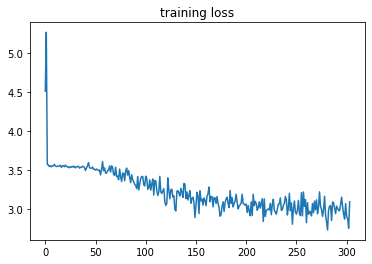

In [16]:
plt.plot(storage['losses']);
plt.title("training loss");